In [40]:
!pip install prophet

**Import** **Dependencies**

In [41]:
import pandas as pd
import numpy as np
import random
from prophet import Prophet
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


Creating a Dataset

In [42]:

# List of public holidays
public_holidays = {
    # 2023 Holidays
    '2023-01-01': 'New Year’s Day',
    '2023-02-20': 'Family Day',  # Example: South Africa
    '2023-03-21': 'Human Rights Day',  # Example: South Africa
    '2023-04-07': 'Good Friday',
    '2023-04-10': 'Easter Monday',
    '2023-04-27': 'Freedom Day',  # Example: South Africa
    '2023-05-01': 'Workers\' Day',
    '2023-06-16': 'Youth Day',  # Example: South Africa
    '2023-08-09': 'Women’s Day',  # Example: South Africa
    '2023-09-24': 'Heritage Day',  # Example: South Africa
    '2023-12-25': 'Christmas',
    '2023-12-26': 'Boxing Day',

    # 2024 Holidays
    '2024-01-01': 'New Year’s Day',
    '2024-02-19': 'Family Day',  # Example: South Africa
    '2024-03-21': 'Human Rights Day',  # Example: South Africa
    '2024-03-29': 'Good Friday',
    '2024-04-01': 'Easter Monday',
    '2024-04-27': 'Freedom Day',  # Example: South Africa
    '2024-05-01': 'Workers\' Day',
    '2024-06-16': 'Youth Day',  # Example: South Africa
    '2024-08-09': 'Women’s Day',  # Example: South Africa
    '2024-09-24': 'Heritage Day',  # Example: South Africa
    '2024-12-25': 'Christmas',
    '2024-12-26': 'Boxing Day',
    '2024-12-31': 'New Year’s Eve',
}

def generate_data(start_date, end_date):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    data = []

    products = ['Milk', 'Bread', 'Eggs', 'Butter', 'Sugar', 'Rice', 'Tea', 'Coffee']
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    event_types = ['Community Fest', 'Festival']
    weather_conditions = ['Cold', 'Mild', 'Warm']

    for date in dates:
        for product in products:  # Record data for all products each day
            day_of_week = date.strftime('%A')
            quantity_sold = random.randint(10, 100)  # Number of units sold
            price = random.uniform(1.0, 10.0)  # Price per unit (random float between 1.0 and 10.0)
            sales = quantity_sold * price  # Total sales for the product
            inventory_level = random.randint(50, 150)  # Inventory level for the product
            season = seasons[(date.month - 1) // 3]  # Simplified season determination
            local_event = random.choice([True, False])  # Randomly determine if a local event happened
            event_type = random.choice(event_types) if local_event else 'N/A'  # Assign proper event type if event occurs
            sales_category = 'Essentials' if product in ['Milk', 'Bread', 'Eggs', 'Butter'] else 'Non-Essentials'
            sales_promotion = random.choice([True, False])
            weather = random.choice(weather_conditions)
            holiday = public_holidays.get(date.strftime('%Y-%m-%d'), 'No Holiday')

            data.append([
                date, day_of_week, quantity_sold, sales, inventory_level, product, season, local_event, event_type,
                sales_category, sales_promotion, weather, holiday
            ])

    df = pd.DataFrame(data, columns=[
        'Date', 'Day of Week', 'Quantity_Sold', 'Sales', 'Inventory_Level', 'Product', 'Season',
        'Local_Event', 'Event_Type', 'Sales_Category', 'Sales_Promotion', 'Weather', 'Holiday'
    ])

    return df

# Example usage
df = generate_data('2023-01-01', '2024-12-31')
print(df.head().to_string(index=False))

      Date Day of Week  Quantity_Sold      Sales  Inventory_Level Product Season  Local_Event Event_Type Sales_Category  Sales_Promotion Weather        Holiday
2023-01-01      Sunday             20  90.611377              143    Milk Winter         True   Festival     Essentials             True    Warm New Year’s Day
2023-01-01      Sunday             33 115.979586               81   Bread Winter        False        N/A     Essentials             True    Warm New Year’s Day
2023-01-01      Sunday             42 387.656575               84    Eggs Winter        False        N/A     Essentials             True    Cold New Year’s Day
2023-01-01      Sunday             41 180.854381               50  Butter Winter         True   Festival     Essentials             True    Mild New Year’s Day
2023-01-01      Sunday             36 150.524383              102   Sugar Winter         True   Festival Non-Essentials            False    Mild New Year’s Day


In [43]:
df.dtypes

,0
Date,datetime64[ns]
Day of Week,object
Quantity_Sold,int64
Sales,float64
Inventory_Level,int64
Product,object
Season,object
Local_Event,bool
Event_Type,object
Sales_Category,object


**Apply Data Preprocessing**

In [44]:
# 1. Standardize Boolean Columns
# Ensure 'Local_Event', 'Sales_Category', and 'Sales_Promotion' are binary (0/1)
df['Local_Event'] = df['Local_Event'].astype(int)  # Convert True/False to 1/0
df['Sales_Category'] = df['Sales_Category'].apply(lambda x: 1 if x == 'Essentials' else 0)
df['Sales_Promotion'] = df['Sales_Promotion'].astype(int)

# 2. Handle Outliers in Numeric Columns (other than 'y' which will be handled by Prophet)
def detect_and_handle_outliers(df, method='IQR', action='remove'):
    # Only apply outlier detection to numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    if method == 'IQR':
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[numeric_columns].quantile(0.25)
        Q3 = df[numeric_columns].quantile(0.75)
        IQR = Q3 - Q1

        # Define the outlier boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Detect outliers
        is_outlier = (df[numeric_columns] < lower_bound) | (df[numeric_columns] > upper_bound)

        if action == 'remove':
            # Remove rows with any outliers
            df_clean = df[~is_outlier.any(axis=1)]
        elif action == 'cap':
            # Cap outliers at the boundary values
            df_clean = df.copy()
            for col in numeric_columns:
                df_clean[col] = np.where(df_clean[col] < lower_bound[col], lower_bound[col], df_clean[col])
                df_clean[col] = np.where(df_clean[col] > upper_bound[col], upper_bound[col], df_clean[col])

    return df_clean

# 3. Ensure Consistent Data Types and Values for Categorical Columns
df['Product'] = df['Product'].astype(str)  # Convert to string in case of any inconsistency
df['Season'] = df['Season'].astype(str)    # Convert to string to avoid numeric conversion issues
df['Weather'] = df['Weather'].astype(str)  # Convert to string for consistency
df['Event_Type'] = df['Event_Type'].astype(str)  # Ensure it's treated as a categorical column
df['Holiday'] = df['Holiday'].astype(str)

print(df.head())  # Check the cleaned data

        Date Day of Week  Quantity_Sold       Sales  Inventory_Level Product  \
0 2023-01-01      Sunday             20   90.611377              143    Milk   
1 2023-01-01      Sunday             33  115.979586               81   Bread   
2 2023-01-01      Sunday             42  387.656575               84    Eggs   
3 2023-01-01      Sunday             41  180.854381               50  Butter   
4 2023-01-01      Sunday             36  150.524383              102   Sugar   

   Season  Local_Event Event_Type  Sales_Category  Sales_Promotion Weather  \
0  Winter            1   Festival               1                1    Warm   
1  Winter            0        N/A               1                1    Warm   
2  Winter            0        N/A               1                1    Cold   
3  Winter            1   Festival               1                1    Mild   
4  Winter            1   Festival               0                0    Mild   

          Holiday  
0  New Year’s Day  
1  New Yea

In [45]:



columns_to_select = ['Date', 'Sales']  # List the columns you want to keep
df_selected = df[columns_to_select]

# Display the new DataFrame with selected columns
print(df_selected)

           Date       Sales
0    2023-01-01   90.611377
1    2023-01-01  115.979586
2    2023-01-01  387.656575
3    2023-01-01  180.854381
4    2023-01-01  150.524383
...         ...         ...
5843 2024-12-31   76.968216
5844 2024-12-31  394.519094
5845 2024-12-31  200.645225
5846 2024-12-31  626.196157
5847 2024-12-31  401.129521

[5848 rows x 2 columns]


In [46]:
df_selected = df_selected.rename(columns={'Date': 'ds', 'Sales': 'y'})

# Display the new DataFrame with renamed columns
print(df_selected)

             ds           y
0    2023-01-01   90.611377
1    2023-01-01  115.979586
2    2023-01-01  387.656575
3    2023-01-01  180.854381
4    2023-01-01  150.524383
...         ...         ...
5843 2024-12-31   76.968216
5844 2024-12-31  394.519094
5845 2024-12-31  200.645225
5846 2024-12-31  626.196157
5847 2024-12-31  401.129521

[5848 rows x 2 columns]


**Step4 Create Time Series Model**

In [47]:
m = Prophet(interval_width=0.95)


In [48]:
training_run = m.fit(df_selected)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9cesixin/2q9fs4md.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9cesixin/cf3i3lsu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98199', 'data', 'file=/tmp/tmp9cesixin/2q9fs4md.json', 'init=/tmp/tmp9cesixin/cf3i3lsu.json', 'output', 'file=/tmp/tmp9cesixin/prophet_modeli40tpx65/prophet_model-20240915203309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:33:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:33:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**Evaluate Model**

In [49]:
future = m.make_future_dataframe(periods=365, freq='D')
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1091,2025-12-27,286.592849,-131.775728,721.992535,270.446810,302.657169,-7.835818,-7.835818,-7.835818,1.025513,1.025513,1.025513,-8.861331,-8.861331,-8.861331,0.0,0.0,0.0,278.757032
1092,2025-12-28,286.556222,-163.940400,649.251283,270.343549,302.682714,-14.198137,-14.198137,-14.198137,-6.163642,-6.163642,-6.163642,-8.034495,-8.034495,-8.034495,0.0,0.0,0.0,272.358085
1093,2025-12-29,286.519595,-159.541487,680.696278,270.240289,302.708258,-10.583247,-10.583247,-10.583247,-3.583575,-3.583575,-3.583575,-6.999672,-6.999672,-6.999672,0.0,0.0,0.0,275.936348
1094,2025-12-30,286.482969,-151.595512,704.803515,270.137028,302.733802,-6.141145,-6.141145,-6.141145,-0.371789,-0.371789,-0.371789,-5.769356,-5.769356,-5.769356,0.0,0.0,0.0,280.341824
1095,2025-12-31,286.446342,-119.420426,673.891096,270.033768,302.759347,-0.288909,-0.288909,-0.288909,4.070832,4.070832,4.070832,-4.359741,-4.359741,-4.359741,0.0,0.0,0.0,286.157433


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


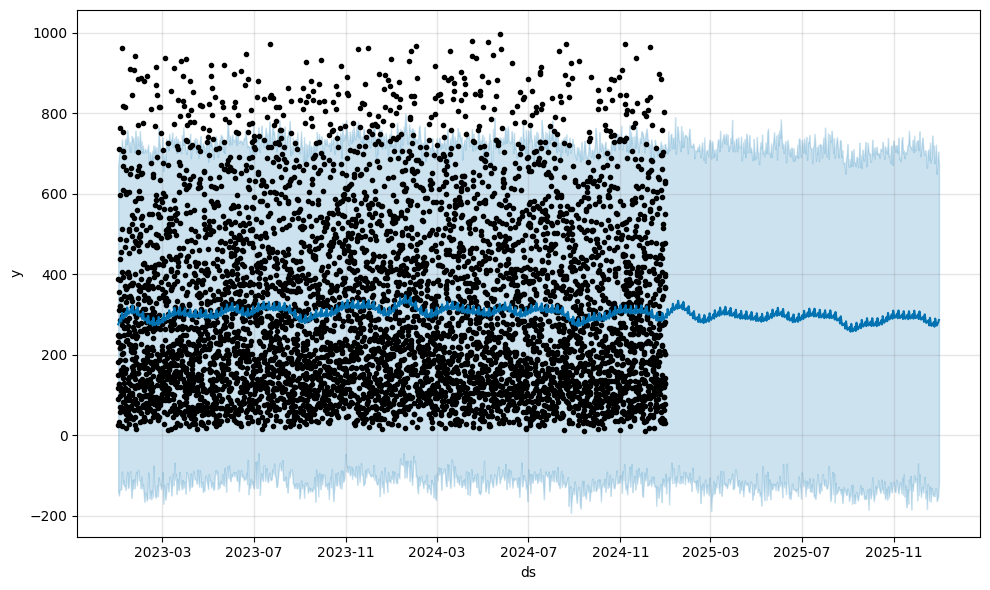

In [50]:
plot1 = m.plot(forecast)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

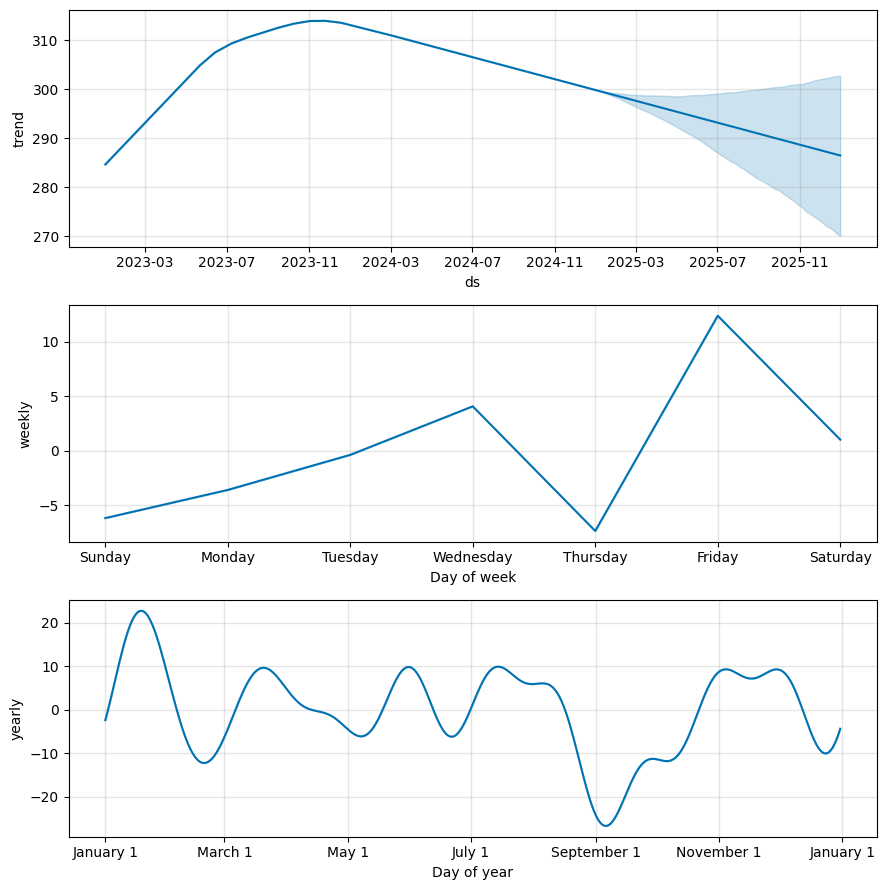

In [51]:
plot2 = m.plot_components(forecast)

How Holidays and Local Events impact Sales


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9cesixin/4kjvb3n7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9cesixin/1rdve69m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55297', 'data', 'file=/tmp/tmp9cesixin/4kjvb3n7.json', 'init=/tmp/tmp9cesixin/1rdve69m.json', 'output', 'file=/tmp/tmp9cesixin/prophet_model9k5zw5x4/prophet_model-20240915203319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:33:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:33:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

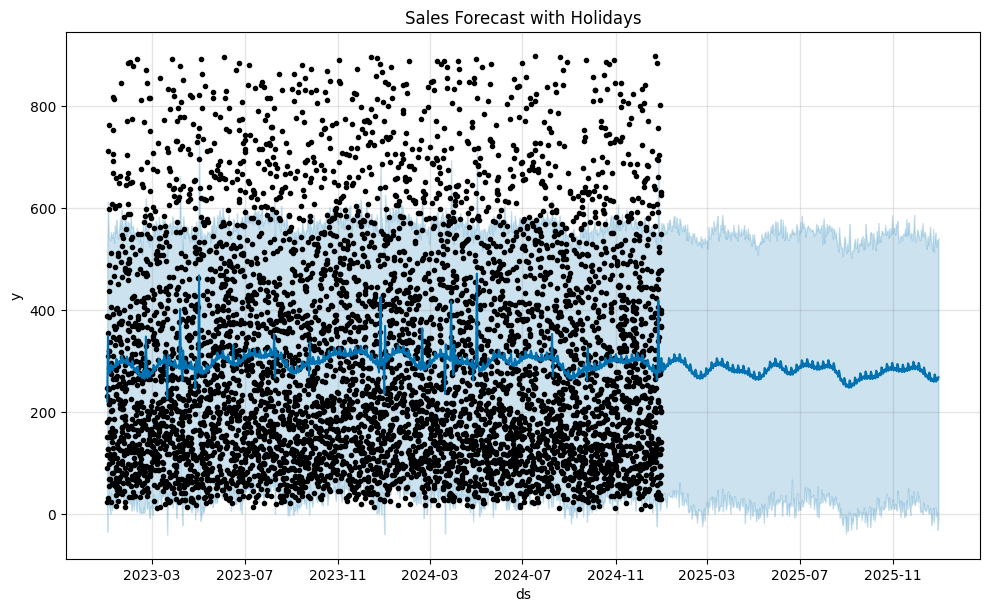

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

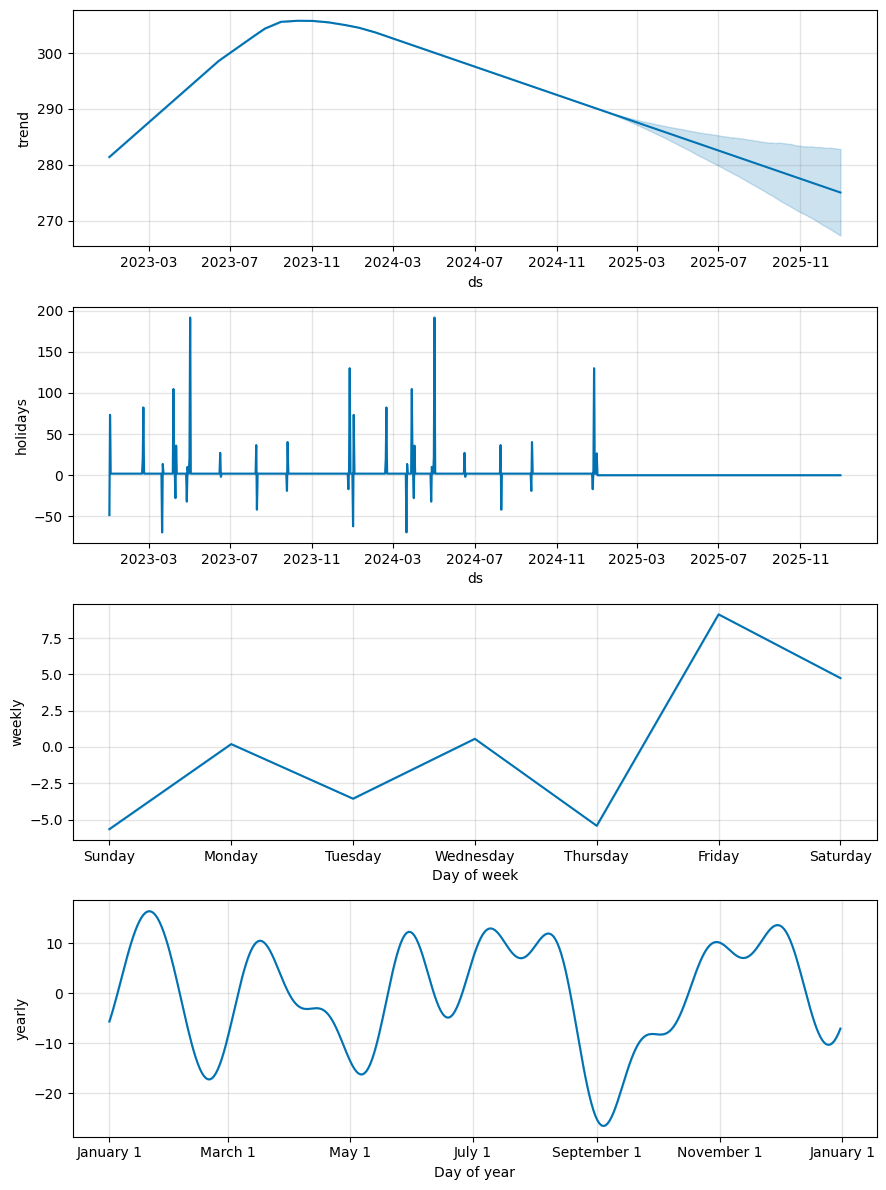

In [52]:
# Standardize Boolean Columns
df['Local_Event'] = df['Local_Event'].astype(int)
df['Sales_Category'] = df['Sales_Category'].apply(lambda x: 1 if x == 'Essentials' else 0)
df['Sales_Promotion'] = df['Sales_Promotion'].astype(int)

# Handle Outliers in Numeric Columns
def detect_and_handle_outliers(df, method='IQR', action='remove'):
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    if method == 'IQR':
        Q1 = df[numeric_columns].quantile(0.25)
        Q3 = df[numeric_columns].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        is_outlier = (df[numeric_columns] < lower_bound) | (df[numeric_columns] > upper_bound)

        if action == 'remove':
            df_clean = df[~is_outlier.any(axis=1)]
        elif action == 'cap':
            df_clean = df.copy()
            for col in numeric_columns:
                df_clean[col] = np.where(df_clean[col] < lower_bound[col], lower_bound[col], df_clean[col])
                df_clean[col] = np.where(df_clean[col] > upper_bound[col], upper_bound[col], df_clean[col])

    return df_clean

# Clean the data by removing outliers
df_clean = detect_and_handle_outliers(df, method='IQR', action='remove')

# Prepare data for Prophet
prophet_df = df_clean[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})

# Prepare holiday data for Prophet
holidays = pd.DataFrame({
    'holiday': df_clean['Holiday'],
    'ds': df_clean['Date'],
    'lower_window': 0,
    'upper_window': 1,
})

# Initialize the Prophet model with holidays
model = Prophet(holidays=holidays)

# Fit the Prophet model to the data
model.fit(prophet_df)

# Create future dates for prediction (365 days ahead)
future = model.make_future_dataframe(periods=365)

# Predict future sales
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title("Sales Forecast with Holidays")
plt.show()

# Plot the components
fig2 = model.plot_components(forecast)
plt.show()


Based on the Prophet model results that incorporate both sales data and holiday information, several key insights and recommendations can be given to the spaza shop owner:

The forecast likely shows a noticeable increase in sales around holidays. This suggests that customers are more likely to shop during these times. Advise the shop owner to prepare by stocking up on high-demand products before holidays.

Focus on Essentials: If sales of essential items are shown to spike during holidays, the owner should prioritize stocking these items in higher quantities. These might include daily-use goods, such as food, household cleaning products, and basic groceries.

Promotions Before Holidays: Use the insights from the forecast to create targeted promotions leading up to holidays. Sales promotions or discounts on essential items before holiday periods can help drive even more sales.
Extend Opening Hours: If sales increase significantly during holidays, consider extending business hours to capture more sales during these peak times.